# Introduction 
The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consits of 60,000 color images of size 32 x 32 collected by by Krizhevsky, Nair, and Hinton. The dataset has 10 classes, each class having 6,000 images which is divided in to two groups: 
* Training: 50,000 images 
* Testing: 10,000 images 


The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

In the following, you will apply different algorithms to the task of object recognition in the images of the aforementioned dataset. Above each cell is a text file with a task for you to complete. 





Importing required packages

In [19]:
import os
import pickle
from collections import Counter

import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras import Input, Model, layers, losses, callbacks, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
#from tensorflow.keras.utils import to_categorical

* Load the data, rescale it and split it into training (train_size=10000), validation (train_size=1000) and test set (train_size=1000)
* Print the shape of your training set
* Print the number of samples in each class
* Compute the mean and standard deviation of your training and test set

In [20]:
# Code for loading the data 
(xtrain_, ytrain), (xtest, ytest) = cifar10.load_data()

# Classes (are given)
classes = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Code for rescaling the images
def preprocess_images(x):
    return x.astype("float32") / 255.0

xtrain = preprocess_images(xtrain_)

# Code for splitting the data into train/val/test set 
Xtrain_, Xrest_, Ytrain, Yrest_ = train_test_split(xtrain, ytrain, train_size=10000 ) 
Xval_, Xrest_, Yval, Yrest_ = train_test_split(Xrest_, Yrest_, train_size=1000)
Xtest_, Xrest_, Ytest, Yrest_ = train_test_split(Xrest_, Yrest_, train_size=10000)

# Code for printing the shape of your training set 
print("Shape of training set", Xtrain_.shape)

# Code for printing the # of samples in each class 
print(Counter(sum(Ytrain.tolist(), [])))

# Code for computing the mean and std of the training and test set
print("Mean {} and Std {} of train set". format(round(np.mean(Xtrain_),2), round(np.std(Xtrain_),2)))
print("Mean {} and Std {} of test set". format(round(np.mean(Xtest_),2), round(np.std(Xtest_),2)))


Shape of training set (10000, 32, 32, 3)
Counter({1: 1031, 6: 1026, 9: 1017, 7: 1010, 3: 1007, 4: 991, 8: 986, 2: 985, 0: 978, 5: 969})
Mean 0.4699999988079071 and Std 0.25 of train set
Mean 0.4699999988079071 and Std 0.25 of test set


Plot a 10 x 10 grid with some random data points, each row representing one of the 10 classes with 10 images from that class.

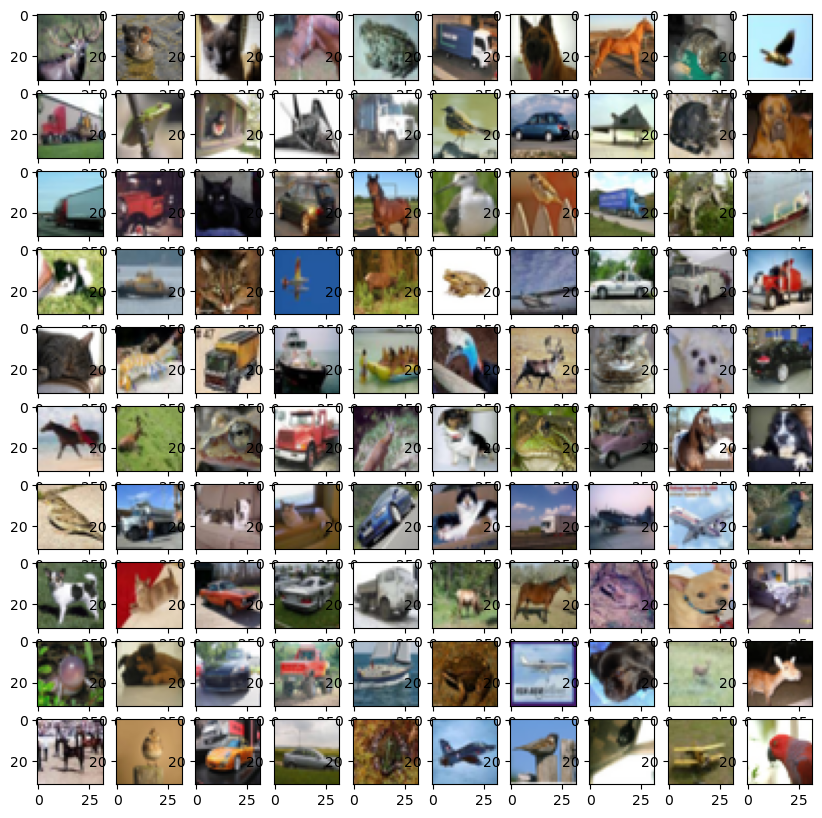

In [3]:
# Code for plotting 
idxs = np.random.choice(len(Xtrain_), 100, replace=False)
fig, axs = plt.subplots(10, 10, figsize=(10,10))
for idx, ax in zip(idxs, axs.flatten()):
    ax.imshow(Xtrain_[idx])
    

Use the convnet from first notebook (Convolutional Neural Network in tensorflow using keras API cell) and train on cifar-10 for **100** epochs. 
* Create a checkpoint to save the best model (see [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/))
* Use the trained model to make predictions on the test data
* Print the **classification_report**
* Print the **confusion_matrix**
* Plot training loss vs. validation loss
* Plot training accuracy vs. validation accuracy 


In [21]:
# Code for training on Cifar-10
def cifar10(input_shape=(32, 32, 3), n_classes=10):
    inx = Input(input_shape)
    x = layers.Conv2D(32, kernel_size=(3,3), strides=2, padding="same", activation="relu")(inx)
    x = layers.Conv2D(64, kernel_size=(3,3), strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, kernel_size=(3,3), strides=2, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(n_classes)(x)
    return Model(inx, x)

clf_cifar10 = cifar10()
clf_cifar10.summary()

# select loss function and optimizer
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
opt = optimizers.Nadam(learning_rate=1e-2)
clf_cifar10.compile(loss=loss,
                    optimizer=opt,
                    metrics=["accuracy"]
                   )

# preprocess data: scaling of images, one-hot encoding of labels
#Ytrain = to_categorical(Ytrain, 10)
#Yval = to_categorical(Yval, 10)

#def preprocess_tf(x, y):
 #   return x, tf.one_hot(y, depth=10, axis=-1)

#trainset = tf.data.Dataset.from_tensor_slices((Xtrain_, Ytrain)).shuffle(Xtrain_.shape[0]).batch(256).map(preprocess_tf)
#valset = tf.data.Dataset.from_tensor_slices((Xval_, Yval)).batch(1000).map(preprocess_tf)

# callback for saving model
MdlCpt = callbacks.ModelCheckpoint("Convnet_cifar10", save_best_only=True)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 32)        896       
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 dense_7 (Dense)             (None, 10)                1290

In [22]:
hist = clf_cifar10.fit(Xtrain_, Ytrain,
                       validation_data=(Xval_, Yval),
                       epochs=2,
                       callbacks=[MdlCpt],
                      )

Epoch 1/2


2022-10-31 01:33:46.955205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 2.3135 - accuracy: 0.1007

2022-10-31 01:33:53.903987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: Convnet_cifar10/assets


INFO:tensorflow:Assets written to: Convnet_cifar10/assets


313/313 [==============================] - 9s 23ms/step - loss: 2.3135 - accuracy: 0.1007 - val_loss: 2.3048 - val_accuracy: 0.1020
Epoch 2/2
313/313 [==============================] - 6s 20ms/step - loss: 2.3041 - accuracy: 0.0991 - val_loss: 2.3058 - val_accuracy: 0.1040


In [23]:
# Code for prediction 
Ypred= tf.argmax(clf_cifar10(Xtest_), axis=-1)

In [24]:
# Code for classification report and confusion matric
print(classification_report(Ytest, Ypred))
print(confusion_matrix(Ytest, Ypred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1039
           1       0.00      0.00      0.00       983
           2       0.00      0.00      0.00      1025
           3       0.00      0.00      0.00      1007
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1004
           6       0.00      0.00      0.00       996
           7       0.10      1.00      0.18       993
           8       0.00      0.00      0.00       992
           9       0.00      0.00      0.00       961

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000

[[   0    0    0    0    0    0    0 1039    0    0]
 [   0    0    0    0    0    0    0  983    0    0]
 [   0    0    0    0    0    0    0 1025    0    0]
 [   0    0    0    0    0    0    0 1007    0    0]
 [   0    0    0    0    0   

/Users/vishy/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vishy/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vishy/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [25]:
hist

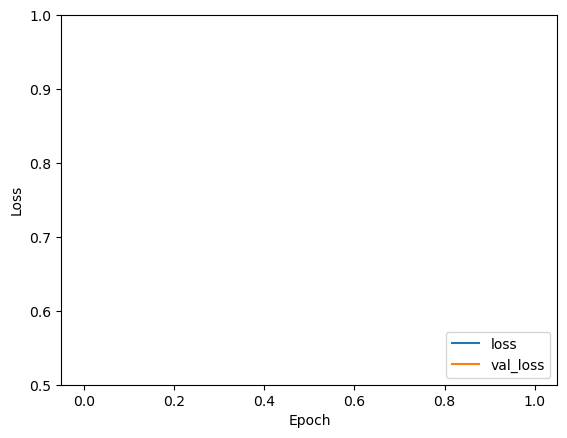

In [26]:
# Code for training loss vs. val loss
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

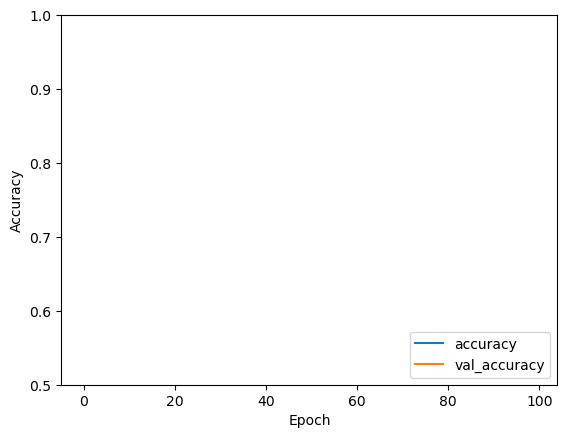

In [10]:
# Code for training acc vs. val acc
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

Use your trained convnet as a feature extractor and feed the output of the flattened layer into a **Support Vector Machine**, which now acts as a classification head (fit an SVC to your training data). Then use the fitted SVC to make predictions on your test data. Print its classification report and the confusion matrix. 

In [ ]:
# Code for the conv feature extractor + SCV classifier


In [ ]:
# Code for making predictions

In [ ]:
# Code for printing classification report and confusion matrix

Implement a NN with the following structure: 
* Input layer -> Conv block 0 -> Conv block 1 -> Conv block 2 -> Conv block 3 -> Dense layer -> Output layer 
* Conv block 0: Conv2D(32, (3,3)) -> Conv2D(32, (3,3))
* Conv block 1: Conv2D(64, (3,3)) -> Conv2D(32, (3,3))
* Conv block 2: Conv2D(128, (3,3)) -> Conv2D(32, (3,3))
* Conv block 3: Conv2D(128, (3,3)) -> Conv2D(32, (3,3))
* Padding is always '**same**', kernel_initializer is '**he_uniform**', and activation function is '**relu**' 
* Dense layer: layers.Flatten() -> layers.Dense(512, activation='relu')
* Output layer: layers.Dense(10) 

* Train this model on the cifar-10 data for 100 epochs and make predictions on the test data
* Create a checkpoint to save the best model (see [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/))
* Print the classification report and confusion matrix
* Plot training loss vs. validation loss
* Plot Training accuracy vs. validation accuracy 
* Did the results improve in comparison to the last model? 

In [ ]:
# Code for model 2 

For the above model, add a batch normalization layer **after each** Conv2D layer. 
* Batch normalization: layers.BatchNormalization()
* You should have two batch normalization layers in each Conv block
* Train this model on the cifar-10 data for 100 epochs and make predictions on the test data
* Create a checkpoint to save the best model (see [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/))
* Print the classification report and confusion matrix
* Plot training loss vs. validation loss
* Plot Training accuracy vs. validation accuracy 
* Did the results improve in comparison to the previous two models?


In [ ]:
# Code for model 3

Apply the following changes to the previous model: 
* In Conv block 0: add a Dropout layer with a rate of 0.1 after the second batch normalization layer 
* In Conv block 1: add a Dropout layer with a rate of 0.2 after the second batch normalization layer
* In Conv block 2: add a Dropout layer with a rate of 0.3 after the second batch normalization layer
* In Conv block 3: add a Dropout layer with a rate of 0.4 after the second batch normalization layer
* Add a Dropout layer after the Dense layer with rate 0.5 
* Dropout layer: layers.Dropout(rate)
* Train this model on the cifar-10 data for 100 epochs and make predictions on the test data
* Create a checkpoint to save the best model (see [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/))
* Print the classification report and confusion matrix
* Plot training loss vs. validation loss
* Plot Training accuracy vs. validation accuracy 
* Did the results improve in comparison to the previous models?



In [ ]:
# Code for model 4 

Apply [image augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) to the previous model. You can use random translation, random flip, and random rotation. 
* Train this model on the cifar-10 data for 200 epochs and make predictions on the test data
* Create a checkpoint to save the best model (see [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/))
* Print the classification report and confusion matrix
* Plot training loss vs. validation loss
* Plot Training accuracy vs. validation accuracy 
* Did the results improve in comparison to the previous models?

In [ ]:
# Code for image augmentation + the rest of the tasks mentioned above

 Create 3D scatter plots (per class) of the first 3 principal components on:
 * Raw images 
 * Simple Convnet features
 * Features of the best performing model 

 Describe your observation from the three plots


In [ ]:
# Code for the three different 3D scatter plots 